# ECG-Classification-keras
#### @based-on https://github.com/SEU-wzx/ECGAI_1D-CNN.git

## Import Packages

In [26]:
import tensorflow as tf
import tensorflow.keras as keras

import random
import numpy as np
import scipy.io as scio
import pandas as pd
import os
import collections
from matplotlib import pyplot as plt

from keras import optimizers
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Set Path

In [27]:
base_path = './'
dataset_path =  './Dataset' # Training data

## Plot Settings

In [28]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

## Data Process

In [29]:
# Variables

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num

## Layers

In [30]:
def nn_base(Unit, Kernel, Conv_Stride, Maxpool_Stride, input_tensor = None):
    
    input_shape = (None, 3)

    ecg_input = input_tensor

    bn_axis = 3

    # nn_base
    x = Conv1D(filters = Unit, kernel_size = Kernel, padding = 'same', strides = Conv_Stride, activation = 'relu', 
               data_format='channels_last')(ecg_input)
    
    x = BatchNormalization()(x)
    
    x = MaxPooling1D(pool_size = 2, strides = Maxpool_Stride, padding = 'same', 
                     data_format='channels_last')(x)

    return x

In [31]:
def classifier_layer(base_layer, dropout_rate = 0.1, ClassesNum = 17):
    
    # classifier layers
    x = Conv1D(filters = 32, kernel_size = 10, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D1', data_format='channels_last')(base_layer)
    
    x = Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu', 
               strides = 2, name = 'classifier_layer_Conv1D2', data_format='channels_last')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D1', data_format='channels_last')(x)
    
    x = Conv1D(filters = 256, kernel_size = 15, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D3', data_format='channels_last')(x)
    
    x = MaxPooling1D(pool_size = 2, strides = 2, padding = 'same', 
                     name = 'classifier_layer_MaxPooling1D2', data_format='channels_last')(x)
    
    x = Conv1D(filters = 512, kernel_size = 5, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D4', data_format='channels_last')(x)
    
    x = Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu', 
               name = 'classifier_layer_Conv1D5', data_format='channels_last')(x)
    
    
    x = Flatten(name = 'classifier_layer_Flatten')(x)
    x = Dense(units = 512, activation = 'relu', name = 'classifier_layer_Dense1')(x)
    x = Dropout(rate = dropout_rate, name = 'classifier_layer_Dropout')(x)
    x = Dense(units = ClassesNum, activation = 'softmax', name = 'classifier_layer_Dense2')(x)
    
    return x

## Dataset Check

In [32]:
# list -> arr
X=np.array(X)
y=np.array(y)

print("total num of training data : ", len(X))

# get X_train, X_test, y_train, y_test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

total num of training data :  1000
X_train :  800
X_test  :  200
y_train :  Counter({0: 229, 3: 106, 6: 103, 13: 79, 1: 55, 14: 52, 7: 45, 16: 36, 5: 16, 2: 15, 4: 13, 8: 11, 12: 9, 15: 8, 11: 8, 10: 8, 9: 7})
y_test  :  Counter({0: 54, 6: 30, 3: 29, 13: 24, 1: 11, 7: 10, 14: 10, 16: 9, 5: 5, 2: 5, 9: 3, 11: 2, 15: 2, 8: 2, 10: 2, 12: 2})
shape of X_train :  (3600,)
shape of y_train :  (800,)
shape of X_test :  (200, 3600)
shape of y_test :  (200,)


## Model Graph

In [33]:
input_ecg = Input(shape=(3600,1))
x = nn_base(128, 50, Conv_Stride = 3, Maxpool_Stride = 3, input_tensor = input_ecg)
x = nn_base(32, 7, Conv_Stride = 1, Maxpool_Stride = 2, input_tensor = x)
output_ecg = classifier_layer(x, dropout_rate = 0.1, ClassesNum = 17)
model_m = Model(input_ecg, output_ecg)
print(model_m.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3600, 1)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1200, 128)         6528      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1200, 128)         512       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 400, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 32)           28704     
_________________________________________________________________
batch_normalization_3 (Batch (None, 400, 32)           128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 200, 32)           0   

## Settings optimizers & compile

In [34]:
# setting optimizers & compile
optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# model_all.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# expand X_train dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.reshape(X_test, (np.shape(X_test)[0], np.shape(X_test)[1], 1))
# Y : int -> binary (one-hot)
y_train = to_categorical(y_train,num_classes = ClassesNum)
y_test = to_categorical(y_test,num_classes = ClassesNum)

display(np.shape(X_train))

(800, 3600, 1)

## Train

In [35]:
BATCH_SIZE = 16
EPOCHS = 50
# history = model_all.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)
history = model_m.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS)

Epoch 1/50
50/50 [==============================] - 4s 60ms/step - loss: 2.5052 - accuracy: 0.2086
Epoch 2/50
50/50 [==============================] - 3s 62ms/step - loss: 2.0856 - accuracy: 0.2941
Epoch 3/50
50/50 [==============================] - 3s 60ms/step - loss: 1.8408 - accuracy: 0.4269
Epoch 4/50
50/50 [==============================] - 3s 61ms/step - loss: 1.7145 - accuracy: 0.4703
Epoch 5/50
50/50 [==============================] - 3s 61ms/step - loss: 1.1910 - accuracy: 0.6394
Epoch 6/50
50/50 [==============================] - 3s 63ms/step - loss: 1.0311 - accuracy: 0.6698
Epoch 7/50
50/50 [==============================] - 3s 61ms/step - loss: 0.7931 - accuracy: 0.7628
Epoch 8/50
50/50 [==============================] - 4s 71ms/step - loss: 0.5783 - accuracy: 0.8120
Epoch 9/50
50/50 [==============================] - 3s 66ms/step - loss: 0.4565 - accuracy: 0.8564
Epoch 10/50
50/50 [==============================] - 3s 63ms/step - loss: 1.0009 - accuracy: 0.8085
Epoch 11/

## Accuracy & Loss

In [36]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy'])
[2.3427681922912598, 1.987329363822937, 1.8014400005340576, 1.570601463317871, 1.1937501430511475, 0.9508256316184998, 0.7323182821273804, 0.5376643538475037, 0.43714767694473267, 0.634662389755249, 0.41646748781204224, 0.2598732113838196, 0.23570387065410614, 0.2677004635334015, 0.24970975518226624, 0.21525247395038605, 0.061090197414159775, 0.02419392764568329, 0.04541950300335884, 0.06796840578317642, 0.05183608829975128, 0.19305258989334106, 0.18832620978355408, 0.141054168343544, 0.179421067237854, 0.057491205632686615, 0.12991838157176971, 0.02059420756995678, 0.03728552907705307, 0.0608806274831295, 0.088812455534935, 0.1778213381767273, 0.13194577395915985, 0.09370153397321701, 0.15467923879623413, 0.11657112836837769, 0.06906001269817352, 0.0918152704834938, 0.1402265578508377, 0.09574760496616364, 0.070820152759552, 0.021018320694565773, 0.008861133828759193, 0.002811494516208768, 0.005491629708558321, 0.011182371526956558, 0.20539125800132751,

## Plot

Text(0.5, 1.0, 'acc')

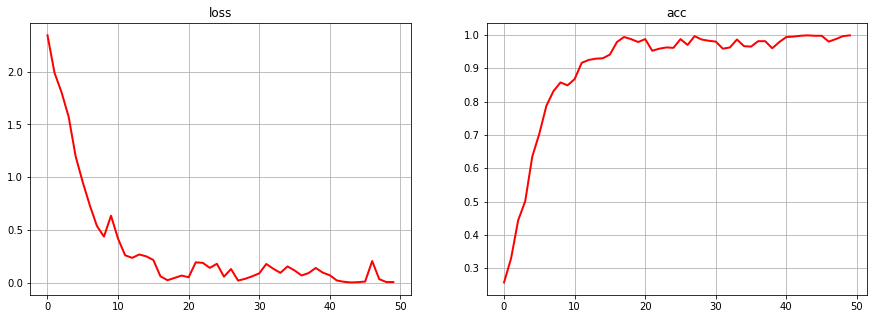

In [37]:

# put into df
record_arr = np.array([history.history['loss'][0], history.history['accuracy'][0]])
for i in range(1, EPOCHS):
    new_row = np.array([history.history['loss'][i], history.history['accuracy'][i]])
    record_arr = np.row_stack((record_arr, new_row))
    
record_df = pd.DataFrame(record_arr, columns=["loss", "acc"])

#print curve
plt.subplot(1,2,1)
plt.plot(np.arange(0, EPOCHS), record_df["loss"], 'r')
plt.title('loss')
plt.subplot(1,2,2)
plt.plot(np.arange(0, EPOCHS), record_df["acc"], 'r')
plt.title('acc')

In [38]:
# val_loss_acc = model_all.evaluate(X_test, y_test, batch_size=100)
val_loss_acc = model_m.evaluate(X_test, y_test, batch_size = 16)
print("loss of val : ", val_loss_acc[0])
print("acc of val : ", val_loss_acc[1])

13/13 [==============================] - 0s 10ms/step - loss: 1.4988 - accuracy: 0.8700
loss of val :  1.4987688064575195
acc of val :  0.8700000047683716


## Predict

In [39]:
# predictions = model_all.predict(X_test)
predictions = model_m.predict(X_test)
display(predictions)

array([[2.5013323e-14, 3.4530350e-17, 6.5172437e-22, ..., 6.4317722e-12,
        1.0628542e-18, 1.8647772e-10],
       [6.0818005e-05, 9.9991202e-01, 4.0590675e-07, ..., 1.2829905e-06,
        3.2782484e-07, 2.9312861e-11],
       [9.9999547e-01, 1.8636602e-08, 1.6344225e-09, ..., 3.1383067e-08,
        4.1585042e-14, 1.8359708e-12],
       ...,
       [6.4464257e-06, 4.1267743e-08, 1.9272330e-10, ..., 2.7586259e-08,
        1.3409931e-10, 8.0808647e-08],
       [9.9999130e-01, 1.8465886e-10, 3.2713932e-11, ..., 1.9975945e-10,
        3.1037309e-16, 5.5864499e-14],
       [1.4074861e-10, 1.9034491e-18, 1.2643538e-24, ..., 1.0000000e+00,
        1.1076470e-22, 1.2229815e-08]], dtype=float32)